# Implementing Grid Search CV on CatBoost

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_validate
import seaborn as sns

In [2]:
ordinal = pd.read_csv('BaseOrdinal.csv')
ordinal.sample(3)

,Unnamed: 0,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
1438,1438,10.0,5.0,1.0,1.0,0.0,3.0,0.0,4.0,1.0,...,1969.0,2.0,898.0,0,173,368,0,0,0,0
1948,1948,5.0,5.0,1.0,1.0,3.0,3.0,0.0,0.0,0.0,...,2001.0,2.0,490.0,120,100,0,0,0,0,0
1590,1590,6.0,5.0,1.0,1.0,3.0,3.0,0.0,4.0,0.0,...,1924.0,1.0,240.0,316,0,120,0,0,0,0


In [3]:
ordinal = ordinal.drop(['Unnamed: 0', 'PID', 'Unnamed: 0.1'], axis=1)
ordinal.shape

(2580, 80)

In [4]:
X = ordinal.drop(['SalePrice'], axis=1)
y = ordinal.SalePrice

In [5]:
cb = CatBoostRegressor(random_state=1, verbose=False, iterations=100)

In [6]:
cb.get_params()

{'iterations': 100,
 'loss_function': 'RMSE',
 'verbose': False,
 'random_state': 1}

## Implementing Grid Search CV with Nested K-Fold

In [24]:
from sklearn.model_selection import GridSearchCV

cv_outer = RepeatedKFold(n_splits=7, random_state=7, n_repeats=1)
cv_inner = RepeatedKFold(n_splits=3, random_state=7, n_repeats=1)
params_cb = {'depth':[6, 8],
             'learning_rate':[0.05, 0.1]}
outer_results = list()

for train_ix, test_ix in cv_outer.split(X,y):
    X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    search = GridSearchCV(estimator=cb, param_grid=params_cb, cv=cv_inner)
    result = search.fit(X_train, y_train)
    print(result.best_params_, result.best_estimator_.score(X_test, y_test))
    outer_results.append(result.best_estimator_.score(X_test, y_test))
 
print(np.mean(outer_results))

{'depth': 6, 'learning_rate': 0.1} 0.9308842069969423
{'depth': 6, 'learning_rate': 0.1} 0.8964552510651411
{'depth': 6, 'learning_rate': 0.1} 0.9149604620785757
{'depth': 6, 'learning_rate': 0.1} 0.9184848511803846
{'depth': 6, 'learning_rate': 0.1} 0.942679503169872
{'depth': 8, 'learning_rate': 0.1} 0.9033108492670336
{'depth': 6, 'learning_rate': 0.1} 0.8647222223215767
0.9102139065827896


In [8]:
# Use cross-validation to evaluate model performance

def evaluate_model(model, X, y):
    
    # define the evaluation procedure
    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
    
    # evaluate the model and collect the results
    scores = cross_validate(model, X, y, cv=cv, n_jobs=-1)
    
    #scores = cross_validate(model, X, y, scoring=scoring, 
    #                              cv=cv, n_jobs=-1) 
    
    df = pd.DataFrame(scores)
    
    return df

In [9]:
cb_gs = CatBoostRegressor(random_state=1, depth=6, learning_rate=0.1)

In [10]:
CAT_GS = evaluate_model(cb_gs, X, y)

0:	learn: 69829.8781767	total: 58.9ms	remaining: 58.9s
1:	learn: 65211.9747454	total: 61.8ms	remaining: 30.9s
2:	learn: 61256.2852197	total: 65.7ms	remaining: 21.8s
3:	learn: 57344.6142851	total: 69.7ms	remaining: 17.3s
4:	learn: 54050.0273663	total: 72.2ms	remaining: 14.4s
5:	learn: 50865.9436254	total: 75.1ms	remaining: 12.4s
6:	learn: 47966.1237815	total: 77.7ms	remaining: 11s
7:	learn: 45635.4529085	total: 80.3ms	remaining: 9.96s
8:	learn: 43606.2895480	total: 83.1ms	remaining: 9.15s
9:	learn: 41595.4018207	total: 88.6ms	remaining: 8.78s
10:	learn: 39771.6775733	total: 93ms	remaining: 8.36s
11:	learn: 37885.7901016	total: 99.2ms	remaining: 8.17s
12:	learn: 36481.7262294	total: 105ms	remaining: 7.93s
13:	learn: 34997.1642931	total: 110ms	remaining: 7.73s
14:	learn: 33619.6090804	total: 116ms	remaining: 7.63s
15:	learn: 32414.3676567	total: 120ms	remaining: 7.38s
16:	learn: 31346.5162267	total: 128ms	remaining: 7.41s
17:	learn: 30354.8052457	total: 132ms	remaining: 7.22s
18:	learn: 2

0:	learn: 70350.2303625	total: 61.4ms	remaining: 1m 1s
1:	learn: 66174.2005868	total: 68.7ms	remaining: 34.3s
2:	learn: 61915.2852906	total: 72.4ms	remaining: 24.1s
3:	learn: 58629.8877270	total: 79.2ms	remaining: 19.7s
4:	learn: 55319.9927086	total: 82.5ms	remaining: 16.4s
5:	learn: 51917.8642010	total: 86.7ms	remaining: 14.4s
6:	learn: 49097.5419672	total: 92.8ms	remaining: 13.2s
7:	learn: 46536.6738583	total: 102ms	remaining: 12.6s
8:	learn: 44120.2644753	total: 106ms	remaining: 11.6s
9:	learn: 42131.5959205	total: 111ms	remaining: 10.9s
10:	learn: 40130.0790455	total: 117ms	remaining: 10.5s
11:	learn: 38193.5291022	total: 121ms	remaining: 9.96s
12:	learn: 36444.2117534	total: 127ms	remaining: 9.64s
13:	learn: 34879.0545956	total: 134ms	remaining: 9.46s
14:	learn: 33594.2473881	total: 140ms	remaining: 9.22s
15:	learn: 32335.9062593	total: 145ms	remaining: 8.89s
16:	learn: 31297.5694706	total: 149ms	remaining: 8.59s
17:	learn: 30256.6313446	total: 155ms	remaining: 8.44s
18:	learn: 29

0:	learn: 70486.9025516	total: 66ms	remaining: 1m 5s
1:	learn: 65957.0440367	total: 71.8ms	remaining: 35.8s
2:	learn: 62130.8772928	total: 77ms	remaining: 25.6s
3:	learn: 58527.3148564	total: 85.9ms	remaining: 21.4s
4:	learn: 54982.4283308	total: 93.6ms	remaining: 18.6s
5:	learn: 51775.8502014	total: 99.3ms	remaining: 16.5s
6:	learn: 48812.8084346	total: 110ms	remaining: 15.6s
7:	learn: 46207.8552316	total: 117ms	remaining: 14.5s
8:	learn: 44188.9456332	total: 127ms	remaining: 14s
9:	learn: 41993.6262408	total: 134ms	remaining: 13.3s
10:	learn: 40012.9376538	total: 142ms	remaining: 12.8s
11:	learn: 38366.9107974	total: 147ms	remaining: 12.1s
12:	learn: 36701.5224420	total: 154ms	remaining: 11.7s
13:	learn: 35140.6598027	total: 158ms	remaining: 11.1s
14:	learn: 33766.8710282	total: 164ms	remaining: 10.8s
15:	learn: 32550.1380932	total: 176ms	remaining: 10.8s
16:	learn: 31448.2041243	total: 183ms	remaining: 10.6s
17:	learn: 30421.9525702	total: 194ms	remaining: 10.6s
18:	learn: 29476.700

149:	learn: 12506.3110152	total: 889ms	remaining: 5.04s
150:	learn: 12446.8768493	total: 893ms	remaining: 5.02s
151:	learn: 12392.4410334	total: 897ms	remaining: 5s
152:	learn: 12337.5209926	total: 902ms	remaining: 5s
153:	learn: 12282.5951923	total: 913ms	remaining: 5.01s
154:	learn: 12244.9630812	total: 919ms	remaining: 5.01s
155:	learn: 12204.9084506	total: 924ms	remaining: 5s
156:	learn: 12186.5160858	total: 931ms	remaining: 5s
157:	learn: 12162.7466624	total: 935ms	remaining: 4.98s
158:	learn: 12124.5476885	total: 941ms	remaining: 4.97s
159:	learn: 12087.3239737	total: 945ms	remaining: 4.96s
160:	learn: 12060.6838488	total: 949ms	remaining: 4.94s
161:	learn: 12025.4359974	total: 953ms	remaining: 4.93s
162:	learn: 11984.8226333	total: 958ms	remaining: 4.92s
163:	learn: 11956.8585868	total: 964ms	remaining: 4.92s
164:	learn: 11907.6020037	total: 970ms	remaining: 4.91s
165:	learn: 11881.0864223	total: 980ms	remaining: 4.92s
166:	learn: 11821.0073047	total: 986ms	remaining: 4.92s
167:

298:	learn: 8512.9313569	total: 1.79s	remaining: 4.19s
299:	learn: 8480.1540036	total: 1.79s	remaining: 4.18s
300:	learn: 8458.1598874	total: 1.79s	remaining: 4.17s
301:	learn: 8433.9155560	total: 1.8s	remaining: 4.16s
302:	learn: 8421.9108639	total: 1.8s	remaining: 4.15s
303:	learn: 8405.3043477	total: 1.81s	remaining: 4.14s
304:	learn: 8384.4187529	total: 1.81s	remaining: 4.13s
305:	learn: 8365.4264263	total: 1.82s	remaining: 4.12s
306:	learn: 8356.2185949	total: 1.82s	remaining: 4.11s
307:	learn: 8348.0064060	total: 1.82s	remaining: 4.1s
308:	learn: 8313.9207697	total: 1.83s	remaining: 4.09s
309:	learn: 8300.5130244	total: 1.83s	remaining: 4.08s
310:	learn: 8295.9956537	total: 1.84s	remaining: 4.07s
311:	learn: 8280.3668430	total: 1.84s	remaining: 4.06s
312:	learn: 8256.9741034	total: 1.84s	remaining: 4.05s
313:	learn: 8240.3076164	total: 1.85s	remaining: 4.04s
314:	learn: 8223.4576759	total: 1.85s	remaining: 4.03s
315:	learn: 8205.0427721	total: 1.85s	remaining: 4.02s
316:	learn: 8

149:	learn: 12964.0838636	total: 1s	remaining: 5.68s
150:	learn: 12913.0540199	total: 1.01s	remaining: 5.68s
151:	learn: 12853.8447815	total: 1.02s	remaining: 5.68s
152:	learn: 12807.7524174	total: 1.03s	remaining: 5.69s
153:	learn: 12761.1296407	total: 1.03s	remaining: 5.67s
154:	learn: 12720.5829639	total: 1.04s	remaining: 5.65s
155:	learn: 12712.4071405	total: 1.04s	remaining: 5.63s
156:	learn: 12648.2743960	total: 1.05s	remaining: 5.62s
157:	learn: 12614.4426182	total: 1.05s	remaining: 5.62s
158:	learn: 12578.4719035	total: 1.06s	remaining: 5.62s
159:	learn: 12551.9019955	total: 1.07s	remaining: 5.61s
160:	learn: 12510.1241101	total: 1.08s	remaining: 5.61s
161:	learn: 12490.0568360	total: 1.08s	remaining: 5.59s
162:	learn: 12439.1036108	total: 1.08s	remaining: 5.57s
163:	learn: 12403.8724519	total: 1.09s	remaining: 5.55s
164:	learn: 12357.4120528	total: 1.1s	remaining: 5.56s
165:	learn: 12316.2493127	total: 1.11s	remaining: 5.56s
166:	learn: 12282.5837578	total: 1.12s	remaining: 5.

149:	learn: 12460.8293804	total: 1.05s	remaining: 5.95s
150:	learn: 12422.5419134	total: 1.05s	remaining: 5.93s
151:	learn: 12380.9057744	total: 1.06s	remaining: 5.91s
152:	learn: 12341.7414430	total: 1.07s	remaining: 5.92s
153:	learn: 12289.7780982	total: 1.07s	remaining: 5.9s
154:	learn: 12258.5460752	total: 1.08s	remaining: 5.9s
155:	learn: 12234.4105905	total: 1.09s	remaining: 5.88s
156:	learn: 12199.9056640	total: 1.09s	remaining: 5.87s
157:	learn: 12189.5215244	total: 1.09s	remaining: 5.84s
158:	learn: 12151.9472516	total: 1.1s	remaining: 5.82s
159:	learn: 12119.4326492	total: 1.11s	remaining: 5.81s
160:	learn: 12078.4687494	total: 1.12s	remaining: 5.83s
161:	learn: 12071.0271742	total: 1.12s	remaining: 5.81s
162:	learn: 12040.9655240	total: 1.13s	remaining: 5.81s
163:	learn: 12031.7681896	total: 1.13s	remaining: 5.78s
164:	learn: 11987.2667714	total: 1.14s	remaining: 5.78s
165:	learn: 11974.8683467	total: 1.15s	remaining: 5.78s
166:	learn: 11922.5096438	total: 1.15s	remaining: 5

598:	learn: 4854.5957036	total: 3.17s	remaining: 2.12s
599:	learn: 4843.0254782	total: 3.17s	remaining: 2.12s
600:	learn: 4837.3007667	total: 3.18s	remaining: 2.11s
601:	learn: 4825.7336672	total: 3.18s	remaining: 2.1s
602:	learn: 4811.6822869	total: 3.19s	remaining: 2.1s
603:	learn: 4803.4686909	total: 3.19s	remaining: 2.09s
604:	learn: 4790.9242839	total: 3.19s	remaining: 2.08s
605:	learn: 4788.7959121	total: 3.19s	remaining: 2.08s
606:	learn: 4778.4997141	total: 3.2s	remaining: 2.07s
607:	learn: 4773.6998883	total: 3.2s	remaining: 2.06s
608:	learn: 4769.7653447	total: 3.21s	remaining: 2.06s
609:	learn: 4763.9702080	total: 3.21s	remaining: 2.05s
610:	learn: 4754.0337713	total: 3.22s	remaining: 2.05s
611:	learn: 4746.7201887	total: 3.22s	remaining: 2.04s
612:	learn: 4735.7797585	total: 3.22s	remaining: 2.04s
613:	learn: 4729.9673215	total: 3.23s	remaining: 2.03s
614:	learn: 4726.0372535	total: 3.23s	remaining: 2.02s
615:	learn: 4718.8843564	total: 3.23s	remaining: 2.02s
616:	learn: 47

297:	learn: 8833.5316877	total: 1.9s	remaining: 4.48s
298:	learn: 8817.1479841	total: 1.91s	remaining: 4.47s
299:	learn: 8794.6826430	total: 1.91s	remaining: 4.46s
300:	learn: 8769.7625812	total: 1.92s	remaining: 4.46s
301:	learn: 8750.2707554	total: 1.94s	remaining: 4.48s
302:	learn: 8733.1355182	total: 1.95s	remaining: 4.49s
303:	learn: 8707.8389201	total: 1.96s	remaining: 4.49s
304:	learn: 8704.5636119	total: 1.97s	remaining: 4.49s
305:	learn: 8677.1814904	total: 1.98s	remaining: 4.5s
306:	learn: 8650.5296928	total: 2s	remaining: 4.52s
307:	learn: 8628.0276451	total: 2.02s	remaining: 4.53s
308:	learn: 8613.7050700	total: 2.04s	remaining: 4.55s
309:	learn: 8587.1413837	total: 2.04s	remaining: 4.55s
310:	learn: 8582.5374174	total: 2.05s	remaining: 4.54s
311:	learn: 8569.0010736	total: 2.05s	remaining: 4.53s
312:	learn: 8547.2703770	total: 2.06s	remaining: 4.52s
313:	learn: 8527.4370986	total: 2.07s	remaining: 4.53s
314:	learn: 8515.8635082	total: 2.08s	remaining: 4.54s
315:	learn: 848

748:	learn: 3871.2616306	total: 3.81s	remaining: 1.28s
749:	learn: 3865.4320043	total: 3.82s	remaining: 1.27s
750:	learn: 3855.5118051	total: 3.82s	remaining: 1.27s
751:	learn: 3847.2576109	total: 3.82s	remaining: 1.26s
752:	learn: 3839.8698831	total: 3.83s	remaining: 1.25s
753:	learn: 3839.2245448	total: 3.83s	remaining: 1.25s
754:	learn: 3839.0754518	total: 3.83s	remaining: 1.24s
755:	learn: 3833.3338800	total: 3.84s	remaining: 1.24s
756:	learn: 3826.9691824	total: 3.84s	remaining: 1.23s
757:	learn: 3824.5886481	total: 3.84s	remaining: 1.23s
758:	learn: 3821.7068930	total: 3.85s	remaining: 1.22s
759:	learn: 3819.0310005	total: 3.86s	remaining: 1.22s
760:	learn: 3811.4755963	total: 3.86s	remaining: 1.21s
761:	learn: 3807.7671681	total: 3.86s	remaining: 1.21s
762:	learn: 3799.9737310	total: 3.87s	remaining: 1.2s
763:	learn: 3797.0855300	total: 3.87s	remaining: 1.2s
764:	learn: 3786.6724864	total: 3.88s	remaining: 1.19s
765:	learn: 3782.0823931	total: 3.88s	remaining: 1.19s
766:	learn: 

898:	learn: 3097.1164564	total: 4.45s	remaining: 500ms
899:	learn: 3093.4196400	total: 4.45s	remaining: 495ms
900:	learn: 3087.3049297	total: 4.46s	remaining: 490ms
901:	learn: 3083.2023250	total: 4.46s	remaining: 485ms
902:	learn: 3079.1112412	total: 4.47s	remaining: 480ms
903:	learn: 3071.5024910	total: 4.47s	remaining: 475ms
904:	learn: 3066.9236109	total: 4.47s	remaining: 470ms
905:	learn: 3066.7240985	total: 4.48s	remaining: 465ms
906:	learn: 3063.5127382	total: 4.48s	remaining: 460ms
907:	learn: 3055.7523279	total: 4.49s	remaining: 454ms
908:	learn: 3052.9013938	total: 4.49s	remaining: 450ms
909:	learn: 3049.6923885	total: 4.5s	remaining: 445ms
910:	learn: 3044.0346116	total: 4.5s	remaining: 440ms
911:	learn: 3039.7816351	total: 4.5s	remaining: 435ms
912:	learn: 3035.2548753	total: 4.51s	remaining: 430ms
913:	learn: 3029.8834306	total: 4.51s	remaining: 424ms
914:	learn: 3028.6978329	total: 4.51s	remaining: 419ms
915:	learn: 3025.7860606	total: 4.52s	remaining: 415ms
916:	learn: 3

447:	learn: 6495.1467359	total: 3.4s	remaining: 4.19s
448:	learn: 6485.4468952	total: 3.41s	remaining: 4.19s
449:	learn: 6471.7923292	total: 3.43s	remaining: 4.19s
450:	learn: 6452.3727164	total: 3.44s	remaining: 4.18s
451:	learn: 6439.4214376	total: 3.45s	remaining: 4.18s
452:	learn: 6421.2016668	total: 3.46s	remaining: 4.17s
453:	learn: 6411.7752932	total: 3.47s	remaining: 4.18s
454:	learn: 6399.2462868	total: 3.48s	remaining: 4.17s
455:	learn: 6385.8937177	total: 3.5s	remaining: 4.17s
456:	learn: 6368.9913777	total: 3.5s	remaining: 4.16s
457:	learn: 6353.7853579	total: 3.51s	remaining: 4.15s
458:	learn: 6336.0050670	total: 3.52s	remaining: 4.15s
459:	learn: 6321.3076394	total: 3.53s	remaining: 4.14s
460:	learn: 6312.7342492	total: 3.53s	remaining: 4.13s
461:	learn: 6301.9596247	total: 3.54s	remaining: 4.13s
462:	learn: 6286.4006763	total: 3.55s	remaining: 4.12s
463:	learn: 6277.7013520	total: 3.56s	remaining: 4.12s
464:	learn: 6257.1565445	total: 3.58s	remaining: 4.11s
465:	learn: 6

47:	learn: 18494.0806980	total: 219ms	remaining: 4.35s
48:	learn: 18367.2542614	total: 223ms	remaining: 4.32s
49:	learn: 18246.8756452	total: 237ms	remaining: 4.5s
50:	learn: 18145.5067388	total: 240ms	remaining: 4.47s
51:	learn: 18036.5733283	total: 244ms	remaining: 4.44s
52:	learn: 17921.2804814	total: 247ms	remaining: 4.42s
53:	learn: 17829.2566080	total: 251ms	remaining: 4.39s
54:	learn: 17742.0565548	total: 257ms	remaining: 4.41s
55:	learn: 17629.8790201	total: 263ms	remaining: 4.44s
56:	learn: 17526.8422171	total: 268ms	remaining: 4.44s
57:	learn: 17393.0425028	total: 274ms	remaining: 4.45s
58:	learn: 17303.1889482	total: 277ms	remaining: 4.42s
59:	learn: 17230.9305358	total: 280ms	remaining: 4.39s
60:	learn: 17143.7804325	total: 289ms	remaining: 4.45s
61:	learn: 17066.6877816	total: 292ms	remaining: 4.41s
62:	learn: 16977.4033220	total: 295ms	remaining: 4.38s
63:	learn: 16888.2685259	total: 301ms	remaining: 4.39s
64:	learn: 16814.5543973	total: 304ms	remaining: 4.37s
65:	learn: 

447:	learn: 6418.2950291	total: 3.75s	remaining: 4.62s
448:	learn: 6404.8172925	total: 3.75s	remaining: 4.61s
449:	learn: 6387.7500088	total: 3.77s	remaining: 4.61s
450:	learn: 6387.2340005	total: 3.77s	remaining: 4.59s
451:	learn: 6372.5281997	total: 3.79s	remaining: 4.59s
452:	learn: 6369.7764539	total: 3.8s	remaining: 4.59s
453:	learn: 6354.0469561	total: 3.81s	remaining: 4.58s
454:	learn: 6338.1157667	total: 3.82s	remaining: 4.57s
455:	learn: 6323.1530843	total: 3.82s	remaining: 4.56s
456:	learn: 6322.7752433	total: 3.83s	remaining: 4.55s
457:	learn: 6309.5363003	total: 3.84s	remaining: 4.54s
458:	learn: 6295.4732062	total: 3.85s	remaining: 4.53s
459:	learn: 6283.9373356	total: 3.85s	remaining: 4.53s
460:	learn: 6272.0791866	total: 3.87s	remaining: 4.52s
461:	learn: 6267.2528891	total: 3.87s	remaining: 4.51s
462:	learn: 6247.0197999	total: 3.89s	remaining: 4.51s
463:	learn: 6232.2238971	total: 3.9s	remaining: 4.5s
464:	learn: 6226.6396100	total: 3.91s	remaining: 4.5s
465:	learn: 62

195:	learn: 11063.1088389	total: 842ms	remaining: 3.45s
196:	learn: 11036.3396118	total: 844ms	remaining: 3.44s
197:	learn: 11006.9722441	total: 848ms	remaining: 3.43s
198:	learn: 10975.9717387	total: 851ms	remaining: 3.42s
199:	learn: 10956.4312473	total: 856ms	remaining: 3.42s
200:	learn: 10927.5149178	total: 858ms	remaining: 3.41s
201:	learn: 10886.4400892	total: 864ms	remaining: 3.41s
202:	learn: 10858.3933812	total: 867ms	remaining: 3.4s
203:	learn: 10856.0979498	total: 869ms	remaining: 3.39s
204:	learn: 10816.8793152	total: 876ms	remaining: 3.4s
205:	learn: 10789.6680908	total: 877ms	remaining: 3.38s
206:	learn: 10785.2159106	total: 882ms	remaining: 3.38s
207:	learn: 10747.0216846	total: 889ms	remaining: 3.39s
208:	learn: 10714.4867715	total: 894ms	remaining: 3.38s
209:	learn: 10688.9142451	total: 898ms	remaining: 3.38s
210:	learn: 10639.4997199	total: 900ms	remaining: 3.36s
211:	learn: 10623.2884323	total: 903ms	remaining: 3.36s
212:	learn: 10586.1291501	total: 909ms	remaining: 

344:	learn: 7945.8165237	total: 1.43s	remaining: 2.71s
345:	learn: 7916.1508540	total: 1.43s	remaining: 2.71s
346:	learn: 7896.7471706	total: 1.44s	remaining: 2.71s
347:	learn: 7880.4569107	total: 1.44s	remaining: 2.7s
348:	learn: 7862.4230733	total: 1.45s	remaining: 2.7s
349:	learn: 7851.0667165	total: 1.45s	remaining: 2.7s
350:	learn: 7849.6245346	total: 1.46s	remaining: 2.69s
351:	learn: 7843.7565596	total: 1.46s	remaining: 2.69s
352:	learn: 7827.5611920	total: 1.47s	remaining: 2.69s
353:	learn: 7801.2050986	total: 1.47s	remaining: 2.68s
354:	learn: 7791.8119722	total: 1.47s	remaining: 2.67s
355:	learn: 7775.3810399	total: 1.47s	remaining: 2.67s
356:	learn: 7756.7749224	total: 1.48s	remaining: 2.66s
357:	learn: 7737.4205214	total: 1.48s	remaining: 2.65s
358:	learn: 7718.7410419	total: 1.49s	remaining: 2.65s
359:	learn: 7694.5277363	total: 1.5s	remaining: 2.66s
360:	learn: 7684.4036223	total: 1.5s	remaining: 2.66s
361:	learn: 7668.8186950	total: 1.5s	remaining: 2.65s
362:	learn: 7649

598:	learn: 4768.5051651	total: 4.93s	remaining: 3.3s
599:	learn: 4760.9204628	total: 4.94s	remaining: 3.29s
600:	learn: 4751.9365524	total: 4.96s	remaining: 3.29s
601:	learn: 4745.8452549	total: 4.97s	remaining: 3.29s
602:	learn: 4745.3962683	total: 4.98s	remaining: 3.28s
603:	learn: 4737.0923210	total: 4.99s	remaining: 3.27s
604:	learn: 4726.3519160	total: 5s	remaining: 3.26s
605:	learn: 4715.1671899	total: 5s	remaining: 3.25s
606:	learn: 4707.5337807	total: 5.01s	remaining: 3.24s
607:	learn: 4696.2576795	total: 5.01s	remaining: 3.23s
608:	learn: 4685.0616645	total: 5.02s	remaining: 3.23s
609:	learn: 4682.0376220	total: 5.03s	remaining: 3.22s
610:	learn: 4672.8272472	total: 5.05s	remaining: 3.21s
611:	learn: 4665.8674635	total: 5.06s	remaining: 3.21s
612:	learn: 4665.5507080	total: 5.07s	remaining: 3.2s
613:	learn: 4657.2566418	total: 5.08s	remaining: 3.19s
614:	learn: 4652.2395838	total: 5.09s	remaining: 3.19s
615:	learn: 4641.9331939	total: 5.1s	remaining: 3.18s
616:	learn: 4625.76

494:	learn: 6087.6350735	total: 2.07s	remaining: 2.11s
495:	learn: 6080.2199875	total: 2.07s	remaining: 2.11s
496:	learn: 6072.7066085	total: 2.08s	remaining: 2.1s
497:	learn: 6070.5539401	total: 2.08s	remaining: 2.1s
498:	learn: 6062.8619782	total: 2.08s	remaining: 2.09s
499:	learn: 6050.7842306	total: 2.08s	remaining: 2.08s
500:	learn: 6046.8874663	total: 2.09s	remaining: 2.08s
501:	learn: 6038.3214205	total: 2.09s	remaining: 2.08s
502:	learn: 6030.6137691	total: 2.1s	remaining: 2.07s
503:	learn: 6006.4440462	total: 2.11s	remaining: 2.07s
504:	learn: 6004.2636286	total: 2.11s	remaining: 2.07s
505:	learn: 5992.8028273	total: 2.11s	remaining: 2.06s
506:	learn: 5982.1826003	total: 2.11s	remaining: 2.06s
507:	learn: 5970.3666673	total: 2.12s	remaining: 2.05s
508:	learn: 5962.7410231	total: 2.12s	remaining: 2.05s
509:	learn: 5950.4851247	total: 2.13s	remaining: 2.04s
510:	learn: 5940.6147947	total: 2.13s	remaining: 2.04s
511:	learn: 5924.7424045	total: 2.13s	remaining: 2.03s
512:	learn: 5

644:	learn: 4855.7840349	total: 2.67s	remaining: 1.47s
645:	learn: 4846.8835254	total: 2.67s	remaining: 1.47s
646:	learn: 4840.9017929	total: 2.68s	remaining: 1.46s
647:	learn: 4840.4386018	total: 2.68s	remaining: 1.46s
648:	learn: 4826.2728532	total: 2.69s	remaining: 1.45s
649:	learn: 4819.5369812	total: 2.69s	remaining: 1.45s
650:	learn: 4807.4961536	total: 2.7s	remaining: 1.45s
651:	learn: 4797.5228438	total: 2.7s	remaining: 1.44s
652:	learn: 4790.6742239	total: 2.7s	remaining: 1.44s
653:	learn: 4790.5337586	total: 2.71s	remaining: 1.43s
654:	learn: 4780.4595782	total: 2.71s	remaining: 1.43s
655:	learn: 4770.7846774	total: 2.72s	remaining: 1.43s
656:	learn: 4765.3153625	total: 2.72s	remaining: 1.42s
657:	learn: 4756.3209767	total: 2.73s	remaining: 1.42s
658:	learn: 4745.1741710	total: 2.73s	remaining: 1.41s
659:	learn: 4736.9732143	total: 2.74s	remaining: 1.41s
660:	learn: 4730.7260493	total: 2.74s	remaining: 1.41s
661:	learn: 4721.4325456	total: 2.75s	remaining: 1.4s
662:	learn: 47

748:	learn: 3891.1555767	total: 6.34s	remaining: 2.13s
749:	learn: 3882.1497283	total: 6.35s	remaining: 2.12s
750:	learn: 3875.3934718	total: 6.36s	remaining: 2.11s
751:	learn: 3867.0073074	total: 6.37s	remaining: 2.1s
752:	learn: 3862.9624726	total: 6.38s	remaining: 2.09s
753:	learn: 3856.4102462	total: 6.39s	remaining: 2.08s
754:	learn: 3849.7907063	total: 6.4s	remaining: 2.08s
755:	learn: 3844.0285031	total: 6.41s	remaining: 2.07s
756:	learn: 3839.8872762	total: 6.41s	remaining: 2.06s
757:	learn: 3834.4213940	total: 6.42s	remaining: 2.05s
758:	learn: 3828.4940792	total: 6.43s	remaining: 2.04s
759:	learn: 3826.9320807	total: 6.44s	remaining: 2.03s
760:	learn: 3819.6990188	total: 6.45s	remaining: 2.03s
761:	learn: 3814.3059536	total: 6.46s	remaining: 2.02s
762:	learn: 3810.1648150	total: 6.47s	remaining: 2.01s
763:	learn: 3802.6068539	total: 6.48s	remaining: 2s
764:	learn: 3790.7709472	total: 6.49s	remaining: 1.99s
765:	learn: 3786.1802403	total: 6.5s	remaining: 1.99s
766:	learn: 3782

898:	learn: 3075.8683552	total: 7.82s	remaining: 878ms
899:	learn: 3071.2366526	total: 7.83s	remaining: 870ms
900:	learn: 3068.1900244	total: 7.84s	remaining: 862ms
901:	learn: 3065.2330129	total: 7.85s	remaining: 853ms
902:	learn: 3062.6538028	total: 7.86s	remaining: 844ms
903:	learn: 3057.7592834	total: 7.87s	remaining: 836ms
904:	learn: 3054.5518954	total: 7.88s	remaining: 828ms
905:	learn: 3050.3967130	total: 7.89s	remaining: 819ms
906:	learn: 3045.7488352	total: 7.9s	remaining: 810ms
907:	learn: 3041.3185679	total: 7.91s	remaining: 802ms
908:	learn: 3038.5924373	total: 7.92s	remaining: 793ms
909:	learn: 3035.1785408	total: 7.94s	remaining: 785ms
910:	learn: 3030.0353181	total: 7.95s	remaining: 777ms
911:	learn: 3024.2528534	total: 7.97s	remaining: 769ms
912:	learn: 3017.3774075	total: 7.97s	remaining: 760ms
913:	learn: 3012.6277311	total: 7.98s	remaining: 751ms
914:	learn: 3009.8290542	total: 7.99s	remaining: 742ms
915:	learn: 3008.8415180	total: 8s	remaining: 733ms
916:	learn: 30

48:	learn: 19154.3235750	total: 340ms	remaining: 6.59s
49:	learn: 19076.5392930	total: 344ms	remaining: 6.54s
50:	learn: 18964.1080894	total: 352ms	remaining: 6.54s
51:	learn: 18860.0011768	total: 356ms	remaining: 6.5s
52:	learn: 18716.3926485	total: 365ms	remaining: 6.53s
53:	learn: 18608.8774489	total: 376ms	remaining: 6.59s
54:	learn: 18460.7917355	total: 387ms	remaining: 6.65s
55:	learn: 18400.4868205	total: 392ms	remaining: 6.61s
56:	learn: 18272.8039235	total: 398ms	remaining: 6.58s
57:	learn: 18189.5402357	total: 407ms	remaining: 6.61s
58:	learn: 18088.1723792	total: 414ms	remaining: 6.6s
59:	learn: 17977.3604293	total: 425ms	remaining: 6.66s
60:	learn: 17832.3382600	total: 436ms	remaining: 6.71s
61:	learn: 17728.4250242	total: 442ms	remaining: 6.68s
62:	learn: 17590.4577426	total: 446ms	remaining: 6.63s
63:	learn: 17459.8748802	total: 450ms	remaining: 6.59s
64:	learn: 17388.3266327	total: 462ms	remaining: 6.64s
65:	learn: 17318.3549855	total: 467ms	remaining: 6.61s
66:	learn: 1

47:	learn: 19241.6646594	total: 369ms	remaining: 7.31s
48:	learn: 19150.8982395	total: 374ms	remaining: 7.26s
49:	learn: 18986.6779243	total: 378ms	remaining: 7.19s
50:	learn: 18833.2953206	total: 384ms	remaining: 7.14s
51:	learn: 18738.1363083	total: 394ms	remaining: 7.18s
52:	learn: 18608.3012686	total: 400ms	remaining: 7.15s
53:	learn: 18514.8190668	total: 410ms	remaining: 7.18s
54:	learn: 18365.8723094	total: 414ms	remaining: 7.11s
55:	learn: 18280.2675551	total: 421ms	remaining: 7.09s
56:	learn: 18186.0819451	total: 426ms	remaining: 7.04s
57:	learn: 18109.1472480	total: 431ms	remaining: 7s
58:	learn: 18032.3027012	total: 436ms	remaining: 6.96s
59:	learn: 17954.5679938	total: 442ms	remaining: 6.92s
60:	learn: 17850.1305518	total: 447ms	remaining: 6.88s
61:	learn: 17781.9114439	total: 450ms	remaining: 6.82s
62:	learn: 17705.5855138	total: 457ms	remaining: 6.79s
63:	learn: 17622.7245819	total: 466ms	remaining: 6.81s
64:	learn: 17520.9143625	total: 474ms	remaining: 6.82s
65:	learn: 17

196:	learn: 10868.0167543	total: 1.11s	remaining: 4.51s
197:	learn: 10852.5177080	total: 1.11s	remaining: 4.5s
198:	learn: 10803.2601869	total: 1.12s	remaining: 4.51s
199:	learn: 10768.3087798	total: 1.12s	remaining: 4.5s
200:	learn: 10746.5955028	total: 1.13s	remaining: 4.5s
201:	learn: 10712.6953470	total: 1.14s	remaining: 4.5s
202:	learn: 10683.4409144	total: 1.15s	remaining: 4.5s
203:	learn: 10650.5863631	total: 1.15s	remaining: 4.49s
204:	learn: 10627.8611383	total: 1.16s	remaining: 4.5s
205:	learn: 10606.7213487	total: 1.16s	remaining: 4.49s
206:	learn: 10575.2900033	total: 1.17s	remaining: 4.49s
207:	learn: 10535.8767819	total: 1.18s	remaining: 4.49s
208:	learn: 10509.9583831	total: 1.18s	remaining: 4.48s
209:	learn: 10483.8475165	total: 1.19s	remaining: 4.47s
210:	learn: 10452.9369381	total: 1.19s	remaining: 4.46s
211:	learn: 10437.6507497	total: 1.2s	remaining: 4.45s
212:	learn: 10419.8514036	total: 1.2s	remaining: 4.45s
213:	learn: 10384.4783269	total: 1.21s	remaining: 4.44s


345:	learn: 7810.4736165	total: 1.78s	remaining: 3.36s
346:	learn: 7795.3086417	total: 1.78s	remaining: 3.35s
347:	learn: 7794.2735137	total: 1.79s	remaining: 3.35s
348:	learn: 7775.4586522	total: 1.79s	remaining: 3.34s
349:	learn: 7758.5873400	total: 1.8s	remaining: 3.34s
350:	learn: 7739.2462235	total: 1.8s	remaining: 3.33s
351:	learn: 7721.8247140	total: 1.8s	remaining: 3.32s
352:	learn: 7702.6351639	total: 1.81s	remaining: 3.31s
353:	learn: 7682.0019575	total: 1.81s	remaining: 3.31s
354:	learn: 7668.0600628	total: 1.81s	remaining: 3.3s
355:	learn: 7656.5294852	total: 1.82s	remaining: 3.29s
356:	learn: 7641.5956928	total: 1.82s	remaining: 3.28s
357:	learn: 7635.5943679	total: 1.82s	remaining: 3.27s
358:	learn: 7612.5660905	total: 1.83s	remaining: 3.27s
359:	learn: 7588.6673657	total: 1.83s	remaining: 3.26s
360:	learn: 7578.2460073	total: 1.84s	remaining: 3.25s
361:	learn: 7552.3572159	total: 1.84s	remaining: 3.24s
362:	learn: 7534.3233059	total: 1.84s	remaining: 3.24s
363:	learn: 75

495:	learn: 5834.1269996	total: 2.49s	remaining: 2.53s
496:	learn: 5831.4203772	total: 2.49s	remaining: 2.52s
497:	learn: 5825.0230460	total: 2.5s	remaining: 2.52s
498:	learn: 5812.1697739	total: 2.5s	remaining: 2.51s
499:	learn: 5808.4841543	total: 2.51s	remaining: 2.51s
500:	learn: 5807.6457640	total: 2.51s	remaining: 2.5s
501:	learn: 5800.0691580	total: 2.51s	remaining: 2.49s
502:	learn: 5798.7074023	total: 2.52s	remaining: 2.49s
503:	learn: 5795.3919008	total: 2.52s	remaining: 2.48s
504:	learn: 5784.2891788	total: 2.52s	remaining: 2.48s
505:	learn: 5778.4920764	total: 2.53s	remaining: 2.47s
506:	learn: 5765.6293333	total: 2.54s	remaining: 2.46s
507:	learn: 5765.1648038	total: 2.54s	remaining: 2.46s
508:	learn: 5748.2516934	total: 2.54s	remaining: 2.45s
509:	learn: 5742.9372112	total: 2.54s	remaining: 2.45s
510:	learn: 5730.0374127	total: 2.55s	remaining: 2.44s
511:	learn: 5712.7340043	total: 2.55s	remaining: 2.43s
512:	learn: 5706.4589199	total: 2.56s	remaining: 2.43s
513:	learn: 5

495:	learn: 5772.2543960	total: 2.56s	remaining: 2.6s
496:	learn: 5757.1918699	total: 2.56s	remaining: 2.6s
497:	learn: 5747.0660977	total: 2.57s	remaining: 2.59s
498:	learn: 5735.1710303	total: 2.57s	remaining: 2.58s
499:	learn: 5720.0023565	total: 2.58s	remaining: 2.58s
500:	learn: 5709.7697940	total: 2.58s	remaining: 2.57s
501:	learn: 5704.0709003	total: 2.59s	remaining: 2.56s
502:	learn: 5691.2197756	total: 2.59s	remaining: 2.56s
503:	learn: 5683.4685979	total: 2.6s	remaining: 2.55s
504:	learn: 5673.4914103	total: 2.6s	remaining: 2.55s
505:	learn: 5661.9030852	total: 2.6s	remaining: 2.54s
506:	learn: 5652.8792500	total: 2.61s	remaining: 2.54s
507:	learn: 5643.4169157	total: 2.61s	remaining: 2.53s
508:	learn: 5638.0500274	total: 2.61s	remaining: 2.52s
509:	learn: 5627.0392909	total: 2.62s	remaining: 2.52s
510:	learn: 5617.9628640	total: 2.62s	remaining: 2.51s
511:	learn: 5617.3075338	total: 2.63s	remaining: 2.51s
512:	learn: 5610.5706249	total: 2.63s	remaining: 2.5s
513:	learn: 5603

645:	learn: 4671.0898523	total: 3.12s	remaining: 1.71s
646:	learn: 4663.3814318	total: 3.12s	remaining: 1.7s
647:	learn: 4653.3142888	total: 3.13s	remaining: 1.7s
648:	learn: 4644.7037462	total: 3.13s	remaining: 1.69s
649:	learn: 4633.7080350	total: 3.13s	remaining: 1.69s
650:	learn: 4629.1393188	total: 3.14s	remaining: 1.68s
651:	learn: 4623.6731542	total: 3.14s	remaining: 1.68s
652:	learn: 4614.9337560	total: 3.15s	remaining: 1.67s
653:	learn: 4599.0891618	total: 3.15s	remaining: 1.67s
654:	learn: 4591.7085158	total: 3.16s	remaining: 1.66s
655:	learn: 4585.5946994	total: 3.16s	remaining: 1.66s
656:	learn: 4578.2140766	total: 3.17s	remaining: 1.65s
657:	learn: 4569.9225441	total: 3.17s	remaining: 1.65s
658:	learn: 4565.6370982	total: 3.17s	remaining: 1.64s
659:	learn: 4562.5332042	total: 3.18s	remaining: 1.64s
660:	learn: 4557.0199296	total: 3.18s	remaining: 1.63s
661:	learn: 4547.7212184	total: 3.19s	remaining: 1.63s
662:	learn: 4543.6479608	total: 3.19s	remaining: 1.62s
663:	learn: 

645:	learn: 4656.0361839	total: 3.24s	remaining: 1.77s
646:	learn: 4640.7647154	total: 3.24s	remaining: 1.77s
647:	learn: 4633.6648486	total: 3.25s	remaining: 1.76s
648:	learn: 4620.5388684	total: 3.25s	remaining: 1.76s
649:	learn: 4620.3363509	total: 3.25s	remaining: 1.75s
650:	learn: 4606.1167557	total: 3.26s	remaining: 1.75s
651:	learn: 4599.8802561	total: 3.27s	remaining: 1.74s
652:	learn: 4590.0826436	total: 3.27s	remaining: 1.74s
653:	learn: 4585.0153871	total: 3.27s	remaining: 1.73s
654:	learn: 4574.9833962	total: 3.28s	remaining: 1.73s
655:	learn: 4573.4315204	total: 3.29s	remaining: 1.72s
656:	learn: 4567.0580236	total: 3.29s	remaining: 1.72s
657:	learn: 4560.9653565	total: 3.3s	remaining: 1.71s
658:	learn: 4548.7344314	total: 3.3s	remaining: 1.71s
659:	learn: 4548.4310599	total: 3.31s	remaining: 1.7s
660:	learn: 4539.8442688	total: 3.32s	remaining: 1.7s
661:	learn: 4539.4216285	total: 3.32s	remaining: 1.7s
662:	learn: 4535.2591432	total: 3.33s	remaining: 1.69s
663:	learn: 452

In [11]:
CAT_GS = CAT_GS[['test_score']].rename(columns={'test_score':'cat_gs_score'})

In [12]:
CAT_GS

,cat_gs_score
0,0.926425
1,0.894369
2,0.935936
3,0.924759
4,0.948708
5,0.934784
6,0.945245
7,0.927991
8,0.945671
9,0.881304


In [13]:
cat_100 = evaluate_model(cb, X, y)

In [14]:
cat_100 = cat_100[['test_score']].rename(columns={'test_score':'cat_100_score'})

In [15]:
cat_100

,cat_100_score
0,0.914519
1,0.896825
2,0.922548
3,0.922437
4,0.937420
5,0.922302
6,0.933590
7,0.911091
8,0.930565
9,0.873520


In [16]:
cb_basic = CatBoostRegressor(random_state=1, verbose=False)

In [17]:
cat = evaluate_model(cb_basic, X, y)

In [18]:
cat = cat[['test_score']].rename(columns={'test_score':'cat_score'})

In [19]:
cat

,cat_score
0,0.926950
1,0.898789
2,0.936517
3,0.929022
4,0.950638
5,0.936688
6,0.942846
7,0.926769
8,0.945508
9,0.884738


In [20]:
combo = pd.concat([cat, CAT_GS, cat_100], axis=1)

In [21]:
combo

,cat_score,cat_gs_score,cat_100_score
0,0.926950,0.926425,0.914519
1,0.898789,0.894369,0.896825
2,0.936517,0.935936,0.922548
3,0.929022,0.924759,0.922437
4,0.950638,0.948708,0.937420
5,0.936688,0.934784,0.922302
6,0.942846,0.945245,0.933590
7,0.926769,0.927991,0.911091
8,0.945508,0.945671,0.930565
9,0.884738,0.881304,0.873520


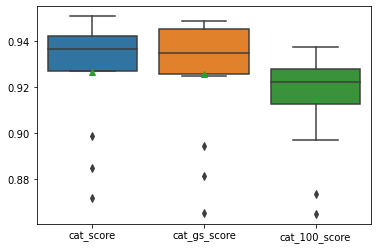

In [22]:
sns.boxplot(data=combo, showmeans=True);

In [23]:
combo.describe()

,cat_score,cat_gs_score,cat_100_score
count,15.000000,15.000000,15.000000
mean,0.926683,0.925643,0.914779
std,0.023191,0.025418,0.021178
min,0.872051,0.865321,0.864915
25%,0.926860,0.925592,0.912495
50%,0.936517,0.934784,0.922302
75%,0.942064,0.945129,0.927984
max,0.950638,0.948708,0.937420
